# Classifying Plant Diseases

In [1]:
from fastai.vision import *

In [2]:
path = Path('data/PlantVillage-Dataset')
path.ls()

[PosixPath('data/PlantVillage-Dataset/Soybean___healthy'),
 PosixPath('data/PlantVillage-Dataset/Strawberry___Leaf_scorch'),
 PosixPath('data/PlantVillage-Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus'),
 PosixPath('data/PlantVillage-Dataset/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'),
 PosixPath('data/PlantVillage-Dataset/Orange___Haunglongbing_(Citrus_greening)'),
 PosixPath('data/PlantVillage-Dataset/Cherry_(including_sour)___Powdery_mildew'),
 PosixPath('data/PlantVillage-Dataset/Apple___Black_rot'),
 PosixPath('data/PlantVillage-Dataset/Tomato___Leaf_Mold'),
 PosixPath('data/PlantVillage-Dataset/Potato___Early_blight'),
 PosixPath('data/PlantVillage-Dataset/Peach___Bacterial_spot'),
 PosixPath('data/PlantVillage-Dataset/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'),
 PosixPath('data/PlantVillage-Dataset/Cherry_(including_sour)___healthy'),
 PosixPath('data/PlantVillage-Dataset/Apple___Cedar_apple_rust'),
 PosixPath('data/PlantVillage-Dataset/Raspberry___healthy'),
 PosixP

In [3]:
import glob
import os
folders = []
for item in glob.glob('data/PlantVillage-Dataset/*'):
    folders.append(os.path.basename(item))

folders[:5]

['Soybean___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)']

In [4]:
# Remove Images that cannot be opened
for c in folders:
    print(c)
    verify_images(path/c, delete=True)

In [5]:
# View Images
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [6]:
data.classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

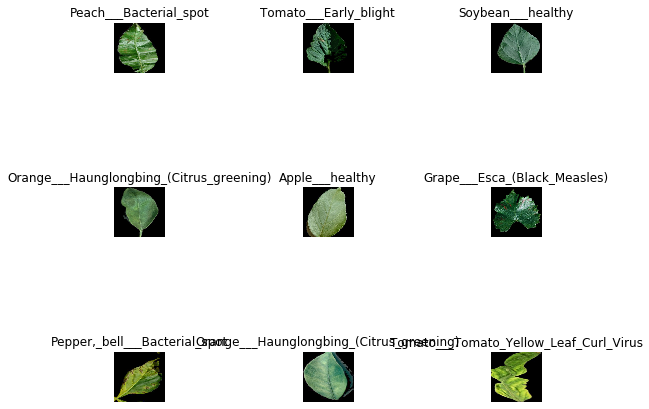

In [11]:
data.show_batch(rows=3, figsize=(8,7))

# Train Model

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.354911,0.180066,0.058374,03:15
1,0.216764,0.089333,0.029647,03:11
2,0.107891,0.057827,0.018599,03:18
3,0.092247,0.052357,0.016665,03:24


In [14]:
learn.save('stage-1')

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


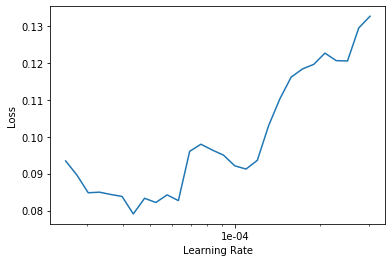

In [17]:
learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [18]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.075419,0.043454,0.013443,03:30
1,0.063600,0.037945,0.011785,03:30


In [19]:
learn.save('stage-2')

# Interpretation

In [20]:
learn.load('stage-2');

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

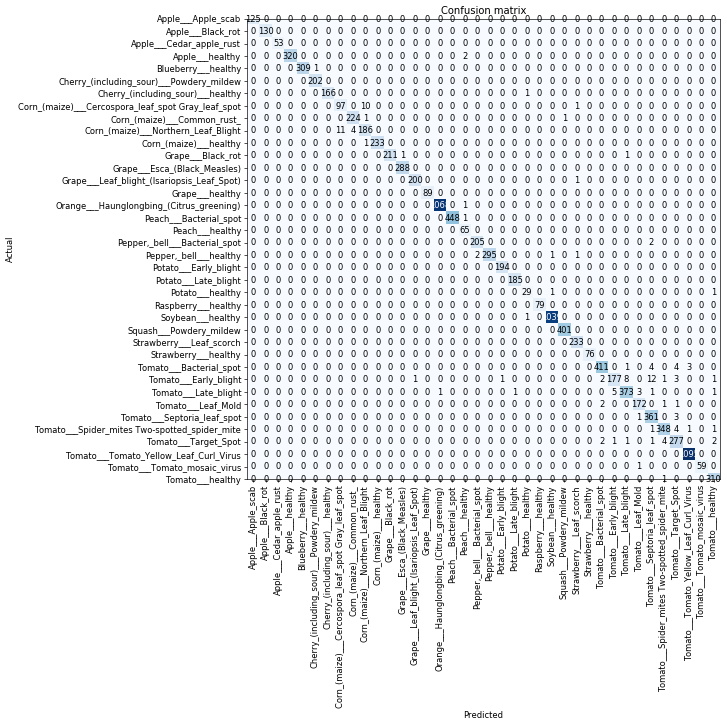

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Putting Model Into Production

In [26]:
learn.export()

In [27]:
defaults.device = torch.device('cpu')

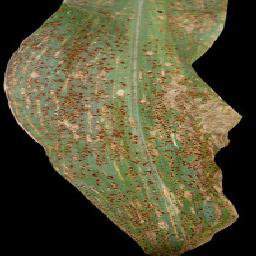

In [28]:
img = open_image(path/'Corn_(maize)___Common_rust_'/'04e947e8-d422-4f48-aa85-a1ec83883465___RS_Rust 2198_final_masked.jpg')
img

In [29]:
learn = load_learner(path)

In [30]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Corn_(maize)___Common_rust_

What the API Might look like:

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)